# Figure 4: Do LLMs agree with human judgments?

In [2]:
import yaml
import random
import json
import pandas as pd
import seaborn as sns
import numpy as np
import typing
from pathlib import Path
from collections import Counter, defaultdict
import matplotlib
from matplotlib import pyplot as plt
from functools import reduce

# import kendall_w.kendall_w as kw
import scipy.stats
from tqdm.auto import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
import math
import statsmodels.api as sm

# import seaborn_image as isns

sns.set_theme()

In [2]:
def ECDF_transform(arr: np.ndarray):
    return ECDF(arr)(arr)

### Data-loading function

In [3]:
ratings = pd.read_csv("./simulate-comb-A-N/beh_stims_9907.csv")
ratings

,item,item_index,count,rt,age,trial_type,rating,adjective,noun
0,African catalog,17362,8,3491.375000,32.375000,crit,0.000000,African,catalog
1,African chance,4587,11,4111.181818,29.636364,crit,-1.090909,African,chance
2,African handset,9820,9,3138.666667,37.111111,crit,-0.666667,African,handset
3,African inception,2021,9,4961.000000,42.666667,crit,-0.111111,African,inception
4,African luxury,11633,8,3817.625000,33.375000,crit,2.125000,African,luxury
...,...,...,...,...,...,...,...,...,...
9902,young screw,257,9,3588.333333,41.333333,crit,-1.333333,young,screw
9903,young socket,14860,8,3872.375000,25.625000,crit,-1.875000,young,socket
9904,young spacecraft,5367,11,4878.000000,27.090909,crit,0.090909,young,spacecraft
9905,young taxi,3659,10,4184.800000,32.500000,crit,-1.700000,young,taxi


In [6]:
len(ratings["adjective"].unique())

651

In [4]:
adj_freq = pd.read_pickle("./simulate-comb-A-N/adj_freqs.pkl")
noun_freq = pd.read_pickle("./simulate-comb-A-N/noun_freqs.pkl")
pair_freq = pd.read_pickle("./simulate-comb-A-N/pair_freq.pkl")

In [5]:
def get_results(
    model="gpt2_xl",
    study="composlang-beh",
    paradigm="logprobs",
    basedir=Path("./llm-results/"),
):
    print(model, study, paradigm)

    [resultsdir] = (basedir / study).glob("benchmark-cfg=*")
    results = list(resultsdir.glob(f"eval={paradigm}*/model={model}/results.csv"))
    results = [pd.read_csv(r, index_col=0) for r in results]
    if len(results) == 2:
        results = pd.merge(*results)
    elif len(results) == 1:
        results = results[0]
    else:
        raise ValueError(f"Found {len(results)} results")

    if paradigm == "likert":
        model_columns = ["text_likert_noun_adjective"]

    if paradigm == "logprobs":
        model_columns = ["logp_A", "logp_N", "logp_N_A"]

    metadata_columns = results.columns.difference(model_columns)

    mii = pd.MultiIndex.from_tuples(
        tuples=[("metadata", c) for c in results.columns if c in metadata_columns]
        + [("model", c) for c in results.columns if c in model_columns],
        # names=levels,
    )
    results.columns = mii
    results["metadata", "model"] = model

    if paradigm == "logprobs":
        col = "logp_N_A"
        ecdf = ECDF_transform(results["model", col])
        results["model", f"ecdf_{col}"] = ecdf

        results["model", "pmi"] = (
            results["model", "logp_N_A"] - results["model", "logp_N"]
        ) / math.log(2)

    results["metadata", "adj_freq"] = (
        results["metadata", "adjective"].apply(str.lower).map(adj_freq)
    )
    results["metadata", "noun_freq"] = (
        results["metadata", "noun"].apply(str.lower).map(noun_freq)
    )
    results["metadata", "pair_freq"] = (
        (results[("metadata", "adjective")] + " " + results[("metadata", "noun")])
        .apply(str.lower)
        .map(pair_freq)
    )
    results.fillna(0, inplace=True)

    # else:
    #     raise NotImplementedError(f"paradigm={paradigm} not in ['likert', 'logprobs']")

    return results.sort_index(axis=1)

In [6]:
mpt30bchat_likert = get_results(model="mpt_30b_chat", paradigm="likert")

mpt_30b_chat composlang-beh likert


ValueError: Found 0 results

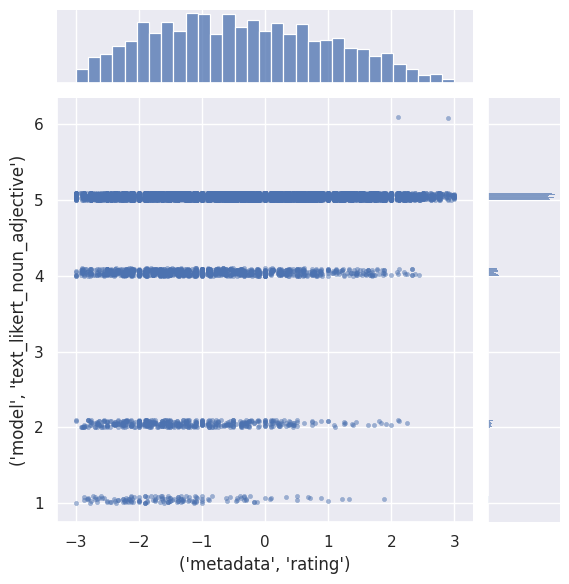

In [14]:
sns.jointplot(
    x=mpt30bchat_likert["metadata", "rating"],
    y=mpt30bchat_likert["model", "text_likert_noun_adjective"]
    + np.random.rand(len(mpt30bchat_likert)) * 0.1,
    edgecolor=None,
    s=10,
    kind="scatter",
    alpha=0.5,
    # bins=100
    # hue=mpt30bchat_likert["metadata", "rating"],
)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
plt.show()

<AxesSubplot:ylabel='Frequency'>

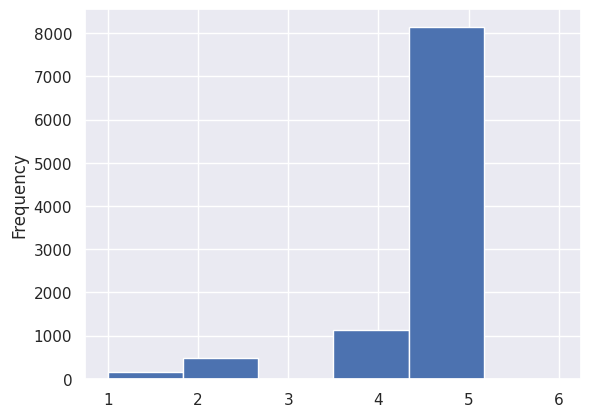

In [ ]:
mpt30bchat_likert["model", "text_likert_noun_adjective"].plot.hist(bins=6)

In [8]:
models = [
    "gpt2_xl",
    "Mistral_7B_v0.1",
    # "phi_2",
    "mpt_7b",
    "mpt_7b_chat",
    "mpt_30b",
    "mpt_30b_chat",
]

In [9]:
gpt2xl = get_results(model="gpt2_xl")
# phi2 = get_results(model="phi_2")
mpt7b = get_results(model="mpt_7b")
mpt7bchat = get_results(model="mpt_7b_chat")
mpt30b = get_results(model="mpt_30b")
mpt_30b_chat = get_results(model="mpt_30b_chat")
mistral7b = get_results(model="Mistral_7B_v0.1")

gpt2_xl composlang-beh logprobs


NameError: name 'ECDF_transform' is not defined

In [ ]:
mpt7b

metadata                                                        \
      adj_freq adjective        age count     id   model        noun   
0      42649.0   African  32.375000     8  17362  mpt_7b     catalog   
1      42649.0   African  29.636364    11   4587  mpt_7b      chance   
2      42649.0   African  37.111111     9   9820  mpt_7b     handset   
3      42649.0   African  42.666667     9   2021  mpt_7b   inception   
4      42649.0   African  33.375000     8  11633  mpt_7b      luxury   
...        ...       ...        ...   ...    ...     ...         ...   
9902  157344.0     young  41.333333     9    257  mpt_7b       screw   
9903  157344.0     young  25.625000     8  14860  mpt_7b      socket   
9904  157344.0     young  27.090909    11   5367  mpt_7b  spacecraft   
9905  157344.0     young  32.500000    10   3659  mpt_7b        taxi   
9906  157344.0     young  29.333333     9   8962  mpt_7b     tobacco   

                                                                   model  \
     noun_freq pair_freq    rating           rt trial_type ecdf_logp_N_A   
0       4895.0       0.0  0.000000  3491.375000       crit      0.292823   
1      62750.0       0.0 -1.090909  4111.181818       crit      0.292823   
2        522.0       0.0 -0.666667  3138.666667       crit      0.151408   
3       1612.0       0.0 -0.111111  4961.000000       crit      0.089634   
4       6061.0       0.0  2.125000  3817.625000       crit      0.890784   
...        ...       ...       ...          ...        ...           ...   
9902    2085.0       0.0 -1.333333  3588.333333       crit      0.484203   
9903    1939.0       0.0 -1.875000  3872.375000       crit      0.221157   
9904    3977.0       0.0  0.090909  4878.000000       crit      0.484203   
9905    4478.0       0.0 -1.700000  4184.800000       crit      0.602907   
9906   10497.0       3.0  0.222222  6871.000000       crit      0.761078   

                                             
       logp_A     logp_N logp_N_A       pmi  
0     -9.9375 -12.312500  -13.250 -1.352527  
1     -9.9375 -10.359375  -13.250 -4.170290  
2     -9.9375 -14.312500  -14.125  0.270505  
3     -9.9375 -14.343750  -14.750 -0.586095  
4     -9.9375 -12.664062  -10.250  3.482756  
...       ...        ...      ...       ...  
9902 -10.0625 -11.562500  -12.375 -1.172190  
9903 -10.0625 -12.687500  -13.625 -1.352527  
9904 -10.0625 -14.781250  -12.375  3.471485  
9905 -10.0625 -12.515625  -11.875  0.924227  
9906 -10.0625 -13.028320  -11.125  2.745911  

[9907 rows x 17 columns]

In [15]:
dfs = {model: get_results(model=model) for model in models}

gpt2_xl composlang-beh logprobs
Mistral_7B_v0.1 composlang-beh logprobs
mpt_7b composlang-beh logprobs
mpt_7b_chat composlang-beh logprobs
mpt_30b composlang-beh logprobs
mpt_30b_chat composlang-beh logprobs


In [16]:
pd.to_pickle(dfs, "./simulate-comb-A-N/llm-composlang-beh.pkl")

In [7]:
dfs = pd.read_pickle("./simulate-comb-A-N/llm-composlang-beh.pkl")

In [12]:
mpt30bchat = dfs["mpt_30b_chat"]
mpt30bchat.sample(5)

metadata                                                                 \
     adj_freq   adjective        age count    id         model          noun   
4516  26822.0  impossible  30.600000    10  2445  mpt_30b_chat        potato   
6596   8859.0     patient  30.777778     9  3743  mpt_30b_chat  interference   
9747  22530.0        wild  38.250000     8  2795  mpt_30b_chat    indication   
4599   9538.0  indigenous  26.625000     8  5906  mpt_30b_chat     editorial   
2261  26370.0     correct  38.250000     8  6408  mpt_30b_chat          chef   

                                                               model  \
     noun_freq pair_freq    rating       rt trial_type ecdf_logp_N_A   
4516    7780.0       0.0 -1.900000  3268.20       crit      0.207833   
6596    3595.0       0.0  1.333333  4798.00       crit      0.626830   
9747    7400.0       0.0 -0.750000  3992.50       crit      0.187443   
4599    5506.0       0.0  0.375000  4116.25       crit      0.400424   
2261   11199.0       0.0  0.250000  4772.75       crit      0.456748   

                                              
        logp_A     logp_N logp_N_A       pmi  
4516 -13.03125 -16.593750 -14.4375  3.110811  
6596 -11.50000 -15.125000 -12.3125  4.057580  
9747 -13.31250 -15.437500 -14.6250  1.172190  
4599 -15.18750 -16.281250 -13.3750  4.192832  
2261 -11.43750 -14.546875 -13.1250  2.051332

In [11]:
from scipy.stats import entropy

In [19]:
entropy(ratings)

9.055107981660552

In [35]:
entropy([1, 2, 2, 1])

1.3296613488547582

In [33]:
entropy([4, 4])

0.6931471805599453

In [44]:
def minmax(array, sum_norm=False):
    array = (array - array.min()) / (array.max() - array.min())
    if sum_norm:
        return array / array.sum()
    return array

In [53]:
adj_freqs = mpt30bchat.groupby(("metadata", "adjective")).mean()["metadata", "adj_freq"]
noun_freqs = mpt30bchat.groupby(("metadata", "noun")).mean()["metadata", "noun_freq"]

In [55]:
ratings = mpt30bchat["metadata", "rating"].copy()
ratings = minmax(ratings)

E_X = entropy(adj_freqs)
E_Y = entropy(noun_freqs)

E_X=5.839, E_Y=7.278
E_X_Y_sim=7.866 I_X_Y_sim=5.251
E_X_Y_hum=9.055 I_X_Y_hum=4.062
E_X_Y_mpt=9.185 I_X_Y_mpt=3.932


In [61]:
X_Y_sim = np.zeros((len(adj_freqs), len(noun_freqs)))
X_Y_mpt = np.zeros((len(adj_freqs), len(noun_freqs)))
adj_ix = {}
noun_ix = {}

for i, row in mpt30bchat.iterrows():
    # print(i, row)
    adj = row[("metadata", "adjective")]
    noun = row[("metadata", "noun")]
    if adj in adj_ix:
        aix = adj_ix[adj]
    else:
        adj_ix[adj] = (aix := len(adj_ix))
    if noun in noun_ix:
        nix = noun_ix[noun]
    else:
        noun_ix[noun] = (nix := len(noun_ix))

    X_Y_sim[aix, nix] = row[("metadata", "adj_freq")] * row[("metadata", "noun_freq")]
    X_Y_mpt[aix, nix] = row[("model", "logp_N_A")]

In [1]:
noun_freqs.shape

NameError: name 'noun_freqs' is not defined

In [73]:
E_X_Y_sim = entropy(X_Y_sim.reshape(-1))
E_X_Y_sim_ = entropy(np.outer(adj_freqs, noun_freqs).reshape(-1))
E_X_Y_hum = entropy(ratings)
E_X_Y_mpt = entropy(minmax(mpt30bchat["model", "logp_N_A"]))
E_X_Y_mpt_ = entropy(X_Y_mpt.reshape(-1))

In [77]:
I_X_Y_sim = E_X + E_Y - E_X_Y_sim
I_X_Y_sim_ = E_X + E_Y - E_X_Y_sim_
I_X_Y_hum = E_X + E_Y - E_X_Y_hum
I_X_Y_mpt = E_X + E_Y - E_X_Y_mpt
I_X_Y_mpt_ = E_X + E_Y - E_X_Y_mpt_

print(f"{E_X=:.3f}, {E_Y=:.3f}")
print()
print(f"{E_X_Y_sim=:.3f}  {I_X_Y_sim=:.3f}")
print(f"{E_X_Y_sim_=:.3f} {I_X_Y_sim_=:.3f}")
print()
print(f"{E_X_Y_hum=:.3f}  {I_X_Y_hum=:.3f}")
print()
print(f"{E_X_Y_mpt=:.3f}  {I_X_Y_mpt=:.3f}")
print(f"{E_X_Y_mpt_=:.3f} {I_X_Y_mpt_=:.3f}")

E_X=5.839, E_Y=7.278

E_X_Y_sim=7.866  I_X_Y_sim=5.251
E_X_Y_sim_=13.117 I_X_Y_sim_=-0.000

E_X_Y_hum=9.055  I_X_Y_hum=4.062

E_X_Y_mpt=9.185  I_X_Y_mpt=3.932
E_X_Y_mpt_=9.188 I_X_Y_mpt_=3.929


In [78]:
def mean_keep_strings(series):
    if series.dtype == object:
        return series.iloc[0]
    else:
        return series.mean()


llm_agg = (
    pd.concat(
        [mpt7b, mpt30b, mpt_30b_chat, mpt7bchat, gpt2xl, mistral7b],
    )
    .groupby([("metadata", "id")])
    .agg(mean_keep_strings)
)
llm_agg["metadata", "model"] = " ".join(models)
llm_agg

metadata                               \
                adj_freq   adjective        age count   
(metadata, id)                                          
0                19448.0   spiritual  28.615385  13.0   
1               102415.0         bad  36.727273  11.0   
2                51582.0   religious  34.222222   9.0   
3                26822.0  impossible  24.375000   8.0   
4                 7256.0    eligible  33.500000   8.0   
...                  ...         ...        ...   ...   
19907            51582.0   religious  30.000000   9.0   
19946            27497.0       thick  23.250000   8.0   
19977                NaN     Western  31.222222   9.0   
19987             4348.0        lead  33.750000   8.0   
20000            56973.0   financial  26.333333   9.0   

                                                                   \
                                                            model   
(metadata, id)                                                      
0               gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
1               gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
2               gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
3               gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
4               gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
...                                                           ...   
19907           gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
19946           gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
19977           gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
19987           gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   
20000           gpt2_xl Mistral_7B_v0.1 mpt_7b mpt_7b_chat mpt...   

                                                                         \
                       noun noun_freq    rating           rt trial_type   
(metadata, id)                                                            
0                   musical    2646.0  1.230769  3636.923077       crit   
1               computation     900.0  2.181818  5594.909091       crit   
2                   geology    1303.0 -2.000000  5666.555556       crit   
3                    chorus    4413.0  0.750000  4195.875000       crit   
4                  grouping    1636.0  1.000000  5707.000000       crit   
...                     ...       ...       ...          ...        ...   
19907               bowling    2189.0 -1.666667  3818.555556       crit   
19946              cassette    1726.0  2.375000  3016.750000       crit   
19977               casting    3051.0  0.222222  6161.666667       crit   
19987               century   78191.0 -1.375000  4824.250000       crit   
20000                  beam    5929.0 -1.222222  6674.000000       crit   

                       model                                             
               ecdf_logp_N_A     logp_A     logp_N   logp_N_A       pmi  
(metadata, id)                                                           
0                   0.831281 -14.248143 -13.460383 -10.916491  3.670060  
1                   0.530113 -11.264094 -14.477635 -12.764855  2.471019  
2                   0.117240 -12.760187 -16.493281 -16.380733  0.162372  
3                   0.122254 -12.824640 -17.249212 -15.613149  2.360339  
4                   0.273864 -14.595799 -13.756398 -14.215706 -0.662641  
...                      ...        ...        ...        ...       ...  
19907               0.265048 -12.760187 -14.878177 -14.329691  0.791298  
19946               0.374415 -14.141372 -16.293667 -13.533199  3.982513  
19977               0.355607 -11.602635 -13.226333 -13.824682 -0.863235  
19987               0.592594 -12.937271 -14.498469 -12.424180  2.992565  
20000               0.139968 -12.126398 -14.131281 -15.236215 -1.594083  

[9907 rows x 15 columns]

In [8]:
def compute_fit(data, target="rating", metric="logp_N_A"):
    y = data["metadata", target]
    x = data["model", metric]
    model = sm.OLS(y, sm.add_constant(x))
    fit = model.fit()

    return fit, dict(
        b=fit.params[0], m=fit.params[1], p=fit.pvalues[1], r2=fit.rsquared
    )


def plot_fit(data, metric="logp_N_A"):
    model_name = data["metadata", "model"].iloc[0]

    fit, info = compute_fit(data, metric=metric)
    b, m = fit.params
    print(fit.summary())
    f, ax = plt.subplots(figsize=(7, 5))

    y = data["metadata", "rating"]
    x = data["model", metric]
    ax.scatter(x, y, alpha=0.5, s=1)
    # ax.set_yscale("log")
    # ax.set_yscale("log")
    # extract intercept b and slope m
    # plot y = m*x + b
    ax.axline(
        xy1=(0, b),
        # xy2=(10, 10 * m + b),
        color="r",
        linewidth=2,
        linestyle="-",
        slope=m,
        label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues[1]:.2f}$",
    )
    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(1, max(y))
    ax.legend(loc="lower right", bbox_to_anchor=(1, 0))
    ax.set_title(f"{model_name} {metric} predict human ratings")
    ax.set_xlabel(model_name + " " + metric)
    ax.set_ylabel("human ratings")

    plt.tight_layout()
    plt.show()

    return fit.rsquared, fit.pvalues.tolist()[1]

In [12]:
y = mpt7b["metadata", "rating"]
x = np.ones(len(y))
# x *= mpt7b["metadata", "rt"]
x *= mpt7b["metadata", "adj_freq"]
x *= mpt7b["metadata", "noun_freq"]

model = sm.OLS(y, sm.add_constant(x))
fit = model.fit()

print(fit.summary())
b, m = fit.params

f, ax = plt.subplots(figsize=(7, 5))

ax.scatter(x, y, alpha=0.5, s=1)
ax.set_xscale("log")
# ax.set_yscale("log")
# extract intercept b and slope m
# plot y = m*x + b
ax.axline(
    xy1=(0, b),
    xy2=(10, 10 * m + b),
    color="r",
    linewidth=2,
    linestyle="-",
    # slope=m,
    label=f"$y = {m:.1f}x {b:+.1f}$; $R^2={fit.rsquared:.3f}$; $p={fit.pvalues.to_list()[1]:.2f}$",
)
# ax.set_xlim(min(x), max(x))
# ax.set_ylim(1, max(y))
ax.legend(loc="lower right", bbox_to_anchor=(1, 0))
ax.set_title(f"lexical frequency to predict human ratings")
ax.set_xlabel("(adj_freq * noun_freq)")
ax.set_ylabel("human ratings")

plt.tight_layout()
plt.show()

NameError: name 'mpt7b' is not defined

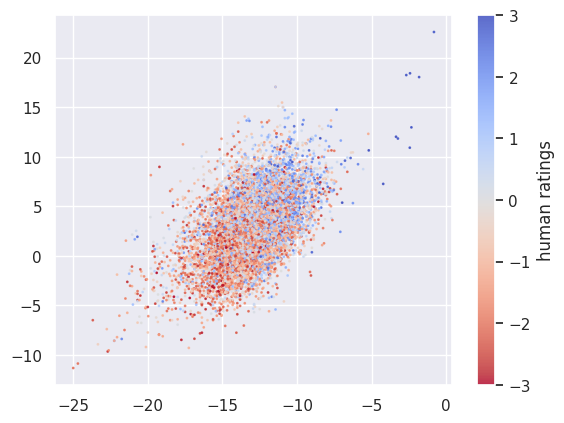

In [112]:
plt.scatter(
    x=mpt_30b_chat["model", "logp_N_A"],
    y=mpt_30b_chat["model", "pmi"],
    s=1,
    alpha=0.8,
    cmap="coolwarm_r",
    c=mpt30b["metadata", "rating"],
)
# plt.xlabel("Mistral_7B_v0.1 $\quad log\;p(N|A)$")
# plt.ylabel("mpt_30b_chat $\quad log\;p(N|A)$")
plt.colorbar(
    label="human ratings",
)
plt.show()

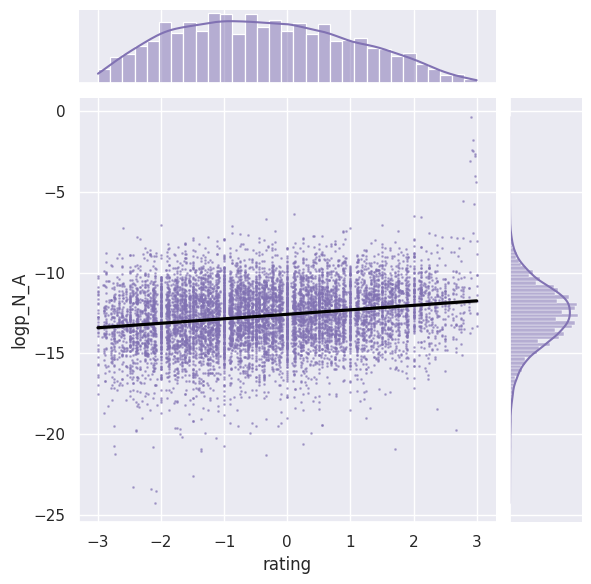

In [128]:
sns.jointplot(
    data=gptlogp,
    y="logp_N_A",
    x="rating",
    kind="reg",
    scatter_kws={"s": 1, "alpha": 0.5},
    line_kws={"color": "black"},
    color="m",
    ci=99,
    # hue="trial_type",
    # edgecolor=None,
    # s=1,
)

In [5]:
dfs.keys()

NameError: name 'dfs' is not defined

gpt2_xl
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.041
Model:                                OLS   Adj. R-squared:                  0.041
Method:                     Least Squares   F-statistic:                     427.3
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           5.54e-93
Time:                            03:45:09   Log-Likelihood:                -16924.
No. Observations:                    9907   AIC:                         3.385e+04
Df Residuals:                        9905   BIC:                         3.387e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

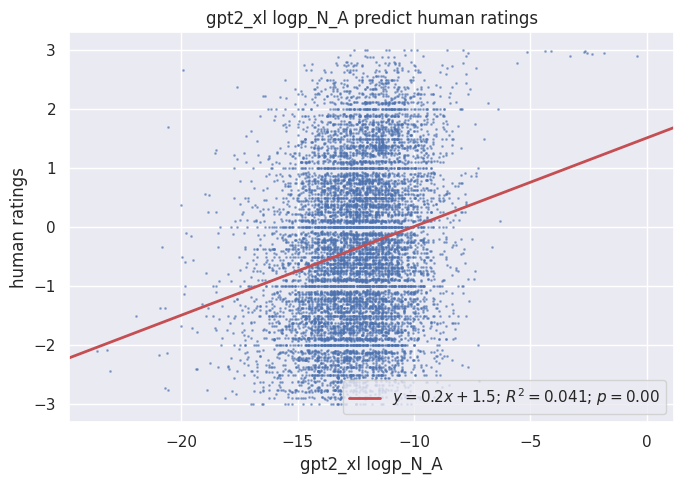

Mistral_7B_v0.1
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.053
Model:                                OLS   Adj. R-squared:                  0.053
Method:                     Least Squares   F-statistic:                     549.9
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):          2.11e-118
Time:                            03:45:09   Log-Likelihood:                -16865.
No. Observations:                    9907   AIC:                         3.373e+04
Df Residuals:                        9905   BIC:                         3.375e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

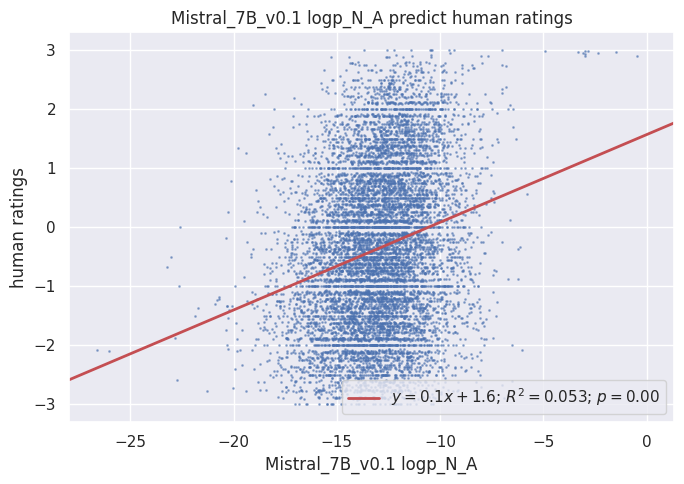

mpt_7b
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.062
Model:                                OLS   Adj. R-squared:                  0.062
Method:                     Least Squares   F-statistic:                     657.2
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):          2.12e-140
Time:                            03:45:10   Log-Likelihood:                -16815.
No. Observations:                    9907   AIC:                         3.363e+04
Df Residuals:                        9905   BIC:                         3.365e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

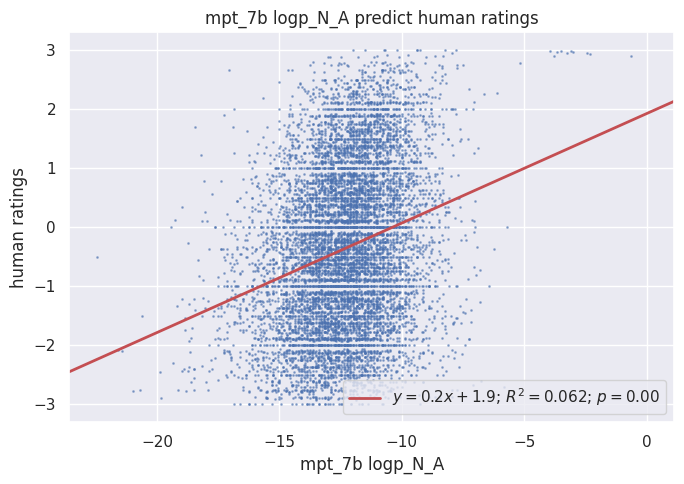

mpt_7b_chat
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.041
Model:                                OLS   Adj. R-squared:                  0.041
Method:                     Least Squares   F-statistic:                     420.4
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):           1.55e-91
Time:                            03:45:10   Log-Likelihood:                -16927.
No. Observations:                    9907   AIC:                         3.386e+04
Df Residuals:                        9905   BIC:                         3.387e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

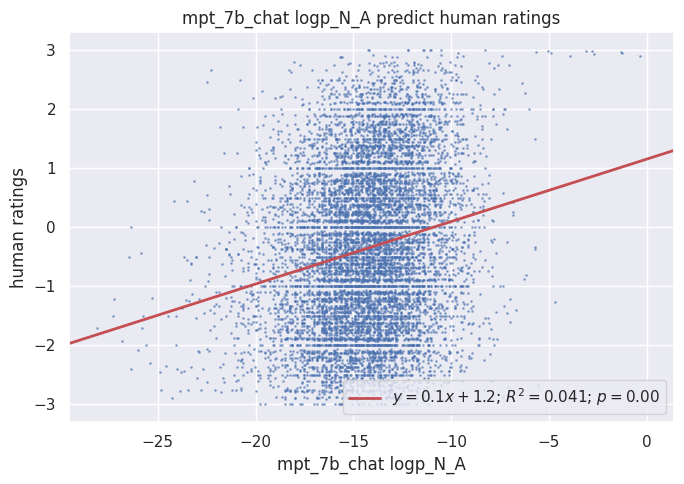

mpt_30b
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.071
Model:                                OLS   Adj. R-squared:                  0.070
Method:                     Least Squares   F-statistic:                     752.3
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):          1.05e-159
Time:                            03:45:10   Log-Likelihood:                -16771.
No. Observations:                    9907   AIC:                         3.355e+04
Df Residuals:                        9905   BIC:                         3.356e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

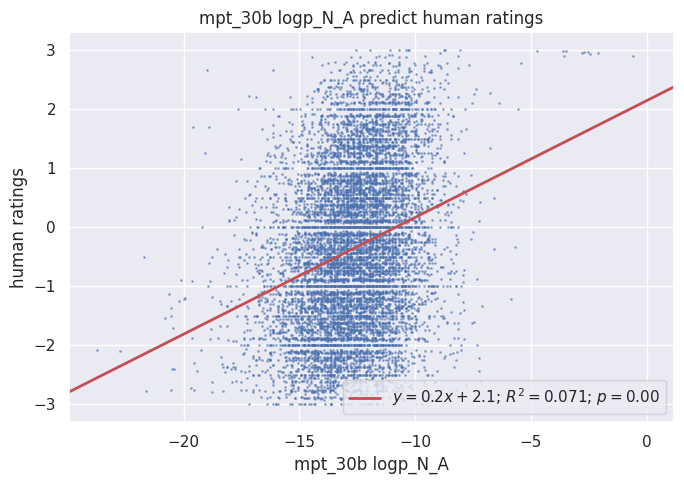

mpt_30b_chat
                              OLS Regression Results                              
Dep. Variable:     ('metadata', 'rating')   R-squared:                       0.058
Model:                                OLS   Adj. R-squared:                  0.058
Method:                     Least Squares   F-statistic:                     606.4
Date:                    Tue, 23 Jan 2024   Prob (F-statistic):          5.33e-130
Time:                            03:45:10   Log-Likelihood:                -16839.
No. Observations:                    9907   AIC:                         3.368e+04
Df Residuals:                        9905   BIC:                         3.370e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

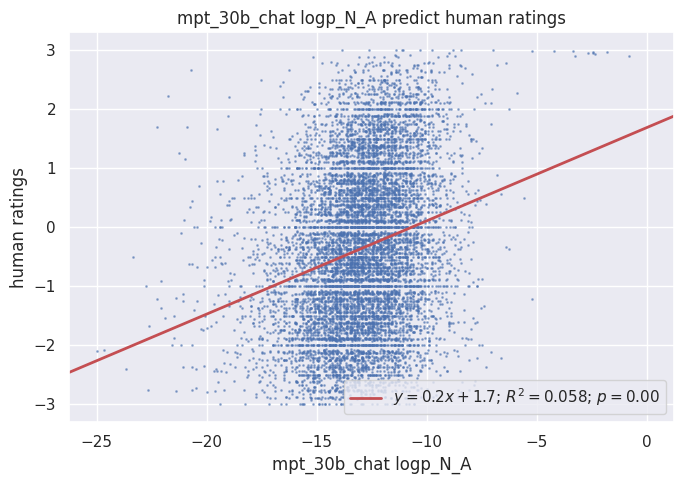

In [9]:
# compare model fits to human data
all_models = []
for model_name in dfs:
    print(model_name)
    r2, p = plot_fit(dfs[model_name], metric="logp_N_A")
    all_models.append(dict(model=model_name, r2=r2, p=p))
all_models = pd.DataFrame(all_models)

In [10]:
all_models["model"] += all_models["p"].apply(lambda val: " (*)" if val < 0.05 else "")

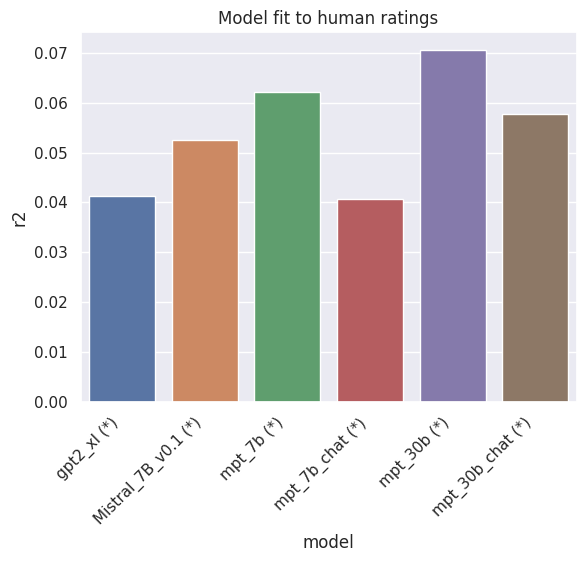

In [11]:
sns.barplot(data=all_models, x="model", y="r2")
# rotate x labels
plt.title("Model fit to human ratings")
plt.xticks(rotation=45, ha="right")
plt.show()